### Anshul Agrawal Student Id : 12211984

In [233]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp
from scipy import stats
import quandl
import functools
import statsmodels
from statsmodels.regression import linear_model as lm
from statsmodels.robust import robust_linear_model as r
import time
import statsmodels.tools.tools as t
import warnings
warnings.filterwarnings("ignore")
import time as tm
from sklearn import linear_model
import statsmodels.graphics.gofplots as sk
import scipy.stats as stats
from sklearn import metrics

In [234]:
quandl.ApiConfig.api_key = "_pYyj-4dy4nxthKZ9hr5"
@functools.lru_cache(maxsize = 16)

def fetch_quandl(my_securities, start_date, end_date):
    qdata = quandl.get(my_securities, returns="pandas", start_date = start_date, end_date = end_date)
    return qdata

#### Reading the Data from the excel file. The excel file contains the pre-defined composition of the ETFs.

In [235]:
xlu = pd.read_excel('ETF Data.xlsx', sheet_name = 'XLU')
vox = pd.read_excel('ETF Data.xlsx', sheet_name = 'VOX')
smh = pd.read_excel('ETF Data.xlsx', sheet_name = 'SMH')
xbi = pd.read_excel('ETF Data.xlsx', sheet_name = 'XBI')
xlf = pd.read_excel('ETF Data.xlsx', sheet_name = 'XLF')
xop = pd.read_excel('ETF Data.xlsx', sheet_name = 'XOP')
oih = pd.read_excel('ETF Data.xlsx', sheet_name = 'OIH')
xrt = pd.read_excel('ETF Data.xlsx', sheet_name = 'XRT')
xlv = pd.read_excel('ETF Data.xlsx', sheet_name = 'XLV')

#### Creating the Unique list of Stocks

In [236]:
final_df = pd.concat([xlu,vox,smh,xbi,xlf,xop,oih,xrt,xlv], axis = 0)
unique_ticker_list = final_df.Ticker.unique()
columns = final_df.ETF.unique()
final_df.head()

,Stock,Ticker,ETF
0,NextEra Energy Inc.,NEE,XLU
1,Duke Energy Corporation,DUK,XLU
2,Dominion Energy Inc,D,XLU
3,Southern Company,SO,XLU
4,Exelon Corporation,EXC,XLU


#### Creating a Dataframe as a reference for identifying the ETFs to which a particular stock belongs

In [237]:
a = pd.DataFrame(columns = columns, index = unique_ticker_list)
a.fillna(0, inplace = True)
a.head()

for i in a.index:
    for j in a.columns:
        for k in range(len(final_df.index)):
            if (i == final_df.iloc[k,1]) and (j == final_df.iloc[k,2]):
                a.loc[i,j] = 1
                
a.head()

,XLU,VOX,SMH,XBI,XLF,XOP,OIH,XRT,XLV
NEE,1,0,0,0,0,0,0,0,0
DUK,1,0,0,0,0,0,0,0,0
D,1,0,0,0,0,0,0,0,0
SO,1,0,0,0,0,0,0,0,0
EXC,1,0,0,0,0,0,0,0,0


#### Fetching the EOD adjusted closing prices of the stocks involved in the analysis

In [238]:
eod_adj_close = fetch_quandl(str('EOD/' + 'MSFT' + '.11'),start_date = '2019-01-01',end_date = '2019-03-31')
eod_adj_close.drop(columns = ['Adj_Close'], inplace = True)

t0 = time.time()

for x in unique_ticker_list:
    tmp = fetch_quandl(str('EOD/' + x + '.11'),start_date = '2019-01-01',end_date = '2019-03-31')
    tmp.rename(columns = {"Adj_Close": x}, inplace = True)
    eod_adj_close = pd.concat([eod_adj_close,tmp], axis = 1)
        
t1 = time.time()
total = t1 - t0
print(total,'Total Time elapsed in seconds to fetch EOD Adjusted Clsoing Prices')

106.37261438369751 Total Time elapsed in seconds to fetch EOD Adjusted Clsoing Prices


In [239]:
eod_adj_close.to_excel('eod_adj_close.xlsx')

#### Fetching EOD adjusted closing prices for the ETFs involved in the analysis 

In [240]:
columns = np.insert(columns,0,'SPY')

t0 = time.time()

eod_adj_close_etfs = fetch_quandl(str('EOD/' + 'QQQ' + '.11'),start_date = '2019-01-01',end_date = '2019-03-31')
eod_adj_close_etfs.rename(columns = {"Adj_Close": 'QQQ'}, inplace = True)

for x in columns:
    tmp = fetch_quandl(str('EOD/' + x + '.11'),start_date = '2019-01-01',end_date = '2019-03-31')
    tmp.rename(columns = {"Adj_Close": x}, inplace = True)
    eod_adj_close_etfs = pd.concat([eod_adj_close_etfs,tmp], axis = 1)
    
t1 = time.time()
total = t1 - t0
print(total,'Total Time elapsed in seconds to fetch EOD Adjusted Closing Prices of the ETFs')

3.1080901622772217 Total Time elapsed in seconds to fetch EOD Adjusted Closing Prices of the ETFs


In [241]:
eod_adj_close_etfs.head()

,QQQ,SPY,XLU,VOX,SMH,XBI,XLF,XOP,OIH,XRT,XLV
Date,,,,,,,,,,,
2019-01-02,154.599123,249.088142,51.628311,74.911264,87.92,72.86,23.899113,27.223245,14.37,41.443272,84.885428
2019-01-03,149.548299,243.144197,51.618384,73.902997,82.64,71.21,23.361831,27.033710,14.49,40.865040,83.161816
2019-01-04,155.946674,251.288497,52.382733,76.967730,86.49,75.02,24.137906,28.559967,15.19,42.121199,85.642622
2019-01-07,157.803301,253.269812,52.025375,77.686495,88.16,79.50,24.167755,29.537570,15.78,43.427205,85.971404
2019-01-08,159.230708,255.649381,52.670605,79.004230,87.65,80.48,24.187654,29.806909,15.94,43.806047,86.638930


#### Computing the daily returns of the stocks and the ETFs

In [242]:
etf_1d_returns = eod_adj_close_etfs.pct_change().dropna()
stocks_1d_returns = eod_adj_close.pct_change().dropna()
stocks_1d_returns.head()

,NEE,DUK,D,SO,EXC,AEP,SRE,PEG,XEL,ED,...,HUM,HCA,ZBH,MCK,ALGN,CNC,CERN,A,IDXX,IQV
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-03,-0.002473,-0.000354,-0.004777,0.014181,0.001135,-0.002331,0.004590,-0.000197,-0.003940,0.002529,...,-0.042225,-0.019054,-0.018088,-0.001150,-0.085791,-0.027257,-0.022556,-0.036840,-0.024334,-0.038054
2019-01-04,0.018417,0.008267,0.019339,0.008345,0.011333,0.009207,0.029930,0.010823,0.009786,0.016195,...,0.025658,0.033071,0.034153,0.012307,0.010445,0.032842,0.030178,0.034614,0.052859,0.046471
2019-01-07,-0.001449,-0.004217,-0.009694,-0.002237,0.001793,-0.005583,-0.000181,0.002141,-0.004330,-0.014500,...,-0.000145,0.008510,0.000385,0.009009,0.017192,0.008544,-0.005744,0.021234,-0.002881,0.018510
2019-01-08,0.007314,0.012587,0.011607,0.028469,0.015436,0.012324,0.027979,0.003885,0.011597,0.006098,...,-0.005966,0.014063,-0.022425,0.020371,0.015954,0.013799,0.023108,0.014660,0.012842,0.020734
2019-01-09,-0.004322,-0.014754,-0.001659,-0.008500,-0.008152,-0.007575,-0.009777,-0.007546,-0.007984,-0.007905,...,0.004801,0.016721,0.008172,0.004673,0.038196,0.018522,0.005647,0.020935,0.015479,0.021149


#### List of Tickers having fat tails
    - I am fetching this list because the reason for opting robust regression methods should become obvious in the following tickers becuase of the large presence of outliers.

In [243]:
fat_tail_tickers = []
for col in unique_ticker_list:
    if sp.stats.kurtosistest(stocks_1d_returns[col])[0] > 5.47:
        fat_tail_tickers.append(col)

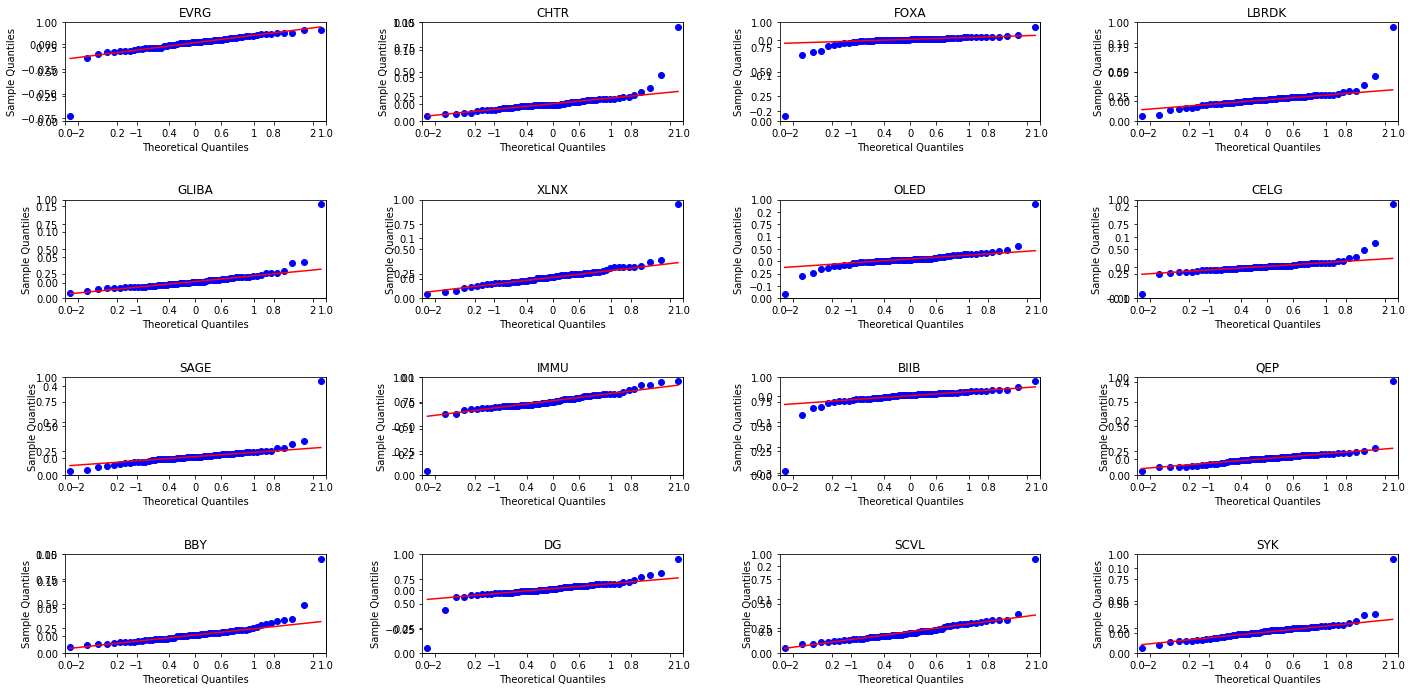

In [244]:
i = 1
from matplotlib import pyplot as plt

fig, ax = plt.subplots(nrows = 4,ncols = 4, figsize = (20, 10))

for k in fat_tail_tickers:
    ax = fig.add_subplot(4, 4, i)
    ax.set_title(k)
    sk.qqplot(stocks_1d_returns[k], ax = ax, line = 'q')
    i = i + 1
    
plt.tight_layout()
plt.show()

####  Conclusion
    1) From the above QQ Plots we can observe that the above stocks have heavy tails. I have analyzed these stocks below because they have heavy tails so i expect to have the effect of robust regression to be prominent in these stocks.

#### Stock Regressors
    1) Below I have inserted the SPY and QQQ return series because we need to regress every stock on these two ETFs along with the ETFs which these stocks are a part of.

In [245]:
a.insert(0,'SPY', 1)
a.insert(0,'QQQ', 1)
a.head()

,QQQ,SPY,XLU,VOX,SMH,XBI,XLF,XOP,OIH,XRT,XLV
NEE,1,1,1,0,0,0,0,0,0,0,0
DUK,1,1,1,0,0,0,0,0,0,0,0
D,1,1,1,0,0,0,0,0,0,0,0
SO,1,1,1,0,0,0,0,0,0,0,0
EXC,1,1,1,0,0,0,0,0,0,0,0


#### Creating a dictionary of dataframes containing the requisite ETF returns for each of the stocks 

In [246]:
regression = {}

for i in a.index:
    tmp = a.loc[i,:] * etf_1d_returns
    tmp = tmp.loc[:, (tmp.sum(axis = 0) != 0)]
    regression[i] = tmp

#### Creating a function to split and compute the data for training and testing out of sample.

In [247]:
def split_data(regressand,regressor, include_constant = False,sep = 45):
    
    if include_constant:
        insample_regressor  = t.add_constant(regressor.iloc[:sep,:])
        outsample_regressor = t.add_constant(regressor.iloc[sep:,:])
    else:
        insample_regressor  = regressor.iloc[:sep,:]
        outsample_regressor = regressor.iloc[sep:,:]
        
    insample_regressand  = regressand.iloc[:sep]
    outsample_regressand = regressand.iloc[sep:]
    
    return insample_regressor,insample_regressand,outsample_regressor,outsample_regressand


###  Huber penalty and Tukey regression

The Huber Penalty function is defined as

$H_k(x) = \frac{1}{2}h_k(x) = \left\{
\begin{array}{ll}
\frac{1}{2}x^2 & |x|\le k\\
k|x|-\frac{1}{2}k^2 &|x|> k
\end{array}\right.
$


Through this analysis, we would like to use python standard $H_k(x)$.This function is a little different from the one provided in the lecture.The coefficient of x^2 is 0.5 whereas in the lecture it was 1.
Also, unless $k$ be specified, $k=1.345$ (as the default value in python) is chosen.

The Tukey function is defined as

$B_k(x) = \frac{k^2}{6}(b_k(x)-1) = \left\{
\begin{array}{ll}
-\frac{k^2}{6}\left(1-(\frac{x}{k})\right) & |x|\le k\\
0 &|x|> k
\end{array}\right.
$

Through this analysis, we would like to use python standard $B_k(x)$.
Unless $k$ be specified, $k=4.685$ (as the default value in python) is chosen.

#### Regression function

In [248]:
def regr(stocks_1d_returns,regression,method = None,include_constant = False, t = 1.345, c = 4.685):
    
    insample_Rsquared_df  = pd.DataFrame(columns = unique_ticker_list,index = ["R-squared"])
    outsample_residuals_df  = pd.DataFrame(columns = unique_ticker_list)
    outsample_standardized_residuals_df = pd.DataFrame(columns = unique_ticker_list)
    outsample_Rsquared_df = pd.DataFrame(columns = unique_ticker_list,index = ["Out of Sample R-squared"])
    
    if method == 'Simple OLS':

        for keys in regression:

            in_rgsor,in_rgsnd,out_rgsor,out_rgsnd = split_data(stocks_1d_returns[keys],regression[keys], include_constant = include_constant) 
            model = lm.OLS(in_rgsnd,in_rgsor)
            res   = model.fit()
            insample_Rsquared_df[keys] = res.rsquared
            outsample_residuals_df[keys] = out_rgsnd - res.predict(out_rgsor)
            outsample_standardized_residuals_df[keys] = outsample_residuals_df[keys]/outsample_residuals_df[keys].std()
            outsample_Rsquared_df[keys] = metrics.r2_score(out_rgsnd,res.predict(out_rgsor))

        return insample_Rsquared_df,outsample_Rsquared_df,outsample_residuals_df,outsample_standardized_residuals_df
    
    elif method == 'Huber Penalty':
        
        for keys in regression:

            in_rgsor,in_rgsnd,out_rgsor,out_rgsnd = split_data(stocks_1d_returns[keys],regression[keys], include_constant = include_constant) 
            model = r.RLM(in_rgsnd,in_rgsor, M = statsmodels.robust.norms.HuberT(t))
            res   = model.fit()
            outsample_residuals_df[keys] = out_rgsnd - res.predict(out_rgsor)
            outsample_standardized_residuals_df[keys] = outsample_residuals_df[keys]/outsample_residuals_df[keys].std()
            outsample_Rsquared_df[keys] = metrics.r2_score(out_rgsnd,res.predict(out_rgsor))
        
        return outsample_residuals_df,outsample_standardized_residuals_df,outsample_Rsquared_df
    
    elif method == 'Tukey':
        
        for keys in regression:

            in_rgsor,in_rgsnd,out_rgsor,out_rgsnd = split_data(stocks_1d_returns[keys],regression[keys], include_constant = include_constant) 
            model = r.RLM(in_rgsnd,in_rgsor, M = statsmodels.robust.norms.TukeyBiweight(c))
            res   = model.fit()
            outsample_residuals_df[keys] = out_rgsnd - res.predict(out_rgsor)
            outsample_standardized_residuals_df[keys] = outsample_residuals_df[keys]/outsample_residuals_df[keys].std()
            outsample_Rsquared_df[keys] = metrics.r2_score(out_rgsnd,res.predict(out_rgsor))
        
        return outsample_residuals_df,outsample_standardized_residuals_df,outsample_Rsquared_df
    
    elif method == 'Lasso':
        
        for keys in regression:
            
            in_rgsor,in_rgsnd,out_rgsor,out_rgsnd = split_data(stocks_1d_returns[keys],regression[keys], include_constant = include_constant) 
            clf = linear_model.Lasso(alpha = 0.1)
            clf.fit(in_rgsor,in_rgsnd)
            outsample_residuals_df[keys] = out_rgsnd - clf.predict(out_rgsor)
            outsample_standardized_residuals_df[keys] = outsample_residuals_df[keys]/outsample_residuals_df[keys].std()
            outsample_Rsquared_df[keys] = metrics.r2_score(out_rgsnd,clf.predict(out_rgsor))
            
        return outsample_residuals_df,outsample_standardized_residuals_df,outsample_Rsquared_df

In [249]:
def plot_distributions(list1,list2):
    
    if len(list1) == 2:
        fig, ax = plt.subplots(nrows = 1,ncols = 2, figsize = (12, 6))
    elif len(list1) == 4:
        fig, ax = plt.subplots(nrows = 1,ncols = 4, figsize = (20, 10))
    else:
        fig, ax = plt.subplots(nrows = 1,ncols = len(list1), figsize = (20, 10))
        
    for i in range(len(list1)):
        ax1 = fig.add_subplot(1,len(list1),i+1)
        ax1.hist(list1[i],facecolor = 'blue', alpha = 0.55, bins = 20)
        plt.ylabel('Frequency', fontsize = 12)
        ax1.set_title(list2[i], fontsize = 12)
        plt.setp(ax1.get_xticklabels(), rotation = 30, horizontalalignment = 'right')
        fig.tight_layout()

#### Anlaysis on with or without intercept

Mean_Out_of_Sample_standardized_errors for fat tail stocks


,Without Intercept,With Intercept
EVRG,0.863789,0.889748
CHTR,0.902282,0.89486
FOXA,0.499637,0.501632
LBRDK,0.863799,0.826045
GLIBA,0.992862,0.816625
XLNX,0.781226,0.758855
OLED,0.830026,1.08019
CELG,0.734822,0.661522
SAGE,0.722569,0.774516
IMMU,0.863244,0.816313


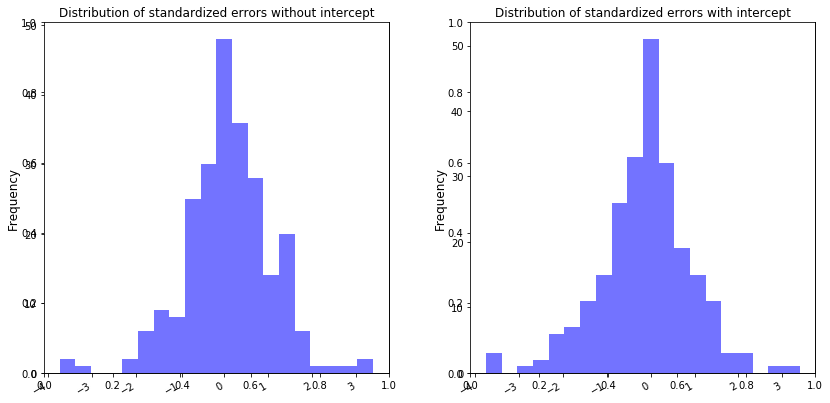

In [250]:
a,j,b,c = regr(stocks_1d_returns,regression,method = 'Simple OLS', include_constant = False)
d,m,e,f = regr(stocks_1d_returns,regression,method = 'Simple OLS', include_constant = True)

# Creating a list of out of sample errors for the fat tail stocks
listc = []
listf = []

# Creating a list of out of sample errors for all the fat tail stocks
for ticker in fat_tail_tickers:
    listc.extend(c[ticker].values)
    
for ticker in fat_tail_tickers:
    listf.extend(f[ticker].values)
    
list1 = [listc,listf]
list2 = ['Distribution of standardized errors without intercept','Distribution of standardized errors with intercept']
plot_distributions(list1,list2)

Mean_Out_of_Sample_errors = pd.DataFrame(index = fat_tail_tickers, columns = ['Without Intercept','With Intercept'])

for s in Mean_Out_of_Sample_errors.index:
    for k in Mean_Out_of_Sample_errors.columns:
        if k == 'Without Intercept':
            Mean_Out_of_Sample_errors.loc[s,'Without Intercept'] = c[s].abs().mean()
        elif k == 'With Intercept':
            Mean_Out_of_Sample_errors.loc[s,'With Intercept'] = f[s].abs().mean()
            
print('Mean_Out_of_Sample_standardized_errors for fat tail stocks')
Mean_Out_of_Sample_errors

#### Conclusion:

    1) The regression without intercept gives slightly better results compared with the case with intercept.As seen from the histogram the distribution of out of sample residuals has both fat left and right tails in the case of no intercept. This implies that introduction of intercept would provide unexpected bias mainly given by the extreme errors.

#### Visualizing Out of Sample Rsquared for Tukey Method with and without intercept

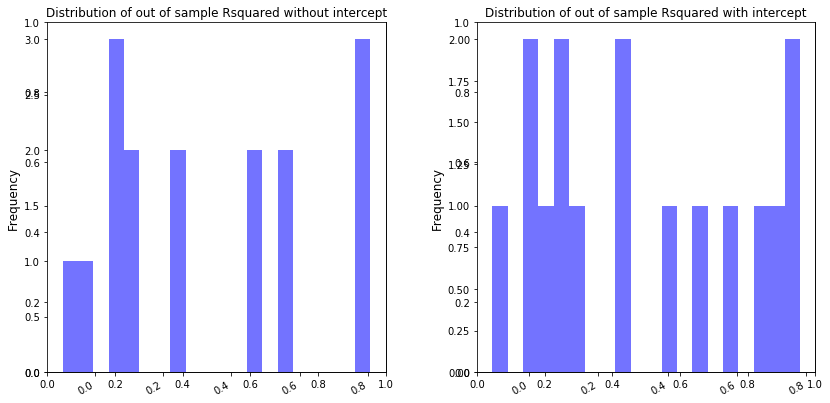

In [251]:
a,b,j = regr(stocks_1d_returns,regression,method = 'Tukey', include_constant = False)
d,e,m = regr(stocks_1d_returns,regression,method = 'Tukey', include_constant = True)

# Creating a list of out of sample errors for the fat tail stocks
listj = []
listm = []

# Creating a list of out of sample errors for all the fat tail stocks
for ticker in fat_tail_tickers:
    listj.append(j[ticker].values[0])
    
for ticker in fat_tail_tickers:
    listm.append(m[ticker].values[0])

list1 = [listj,listm]
list2 = ['Distribution of out of sample Rsquared without intercept','Distribution of out of sample Rsquared with intercept']
plot_distributions(list1,list2)

#### Conclusion:
    Looking at the above histogram, we can infer that the out of sample R2 looks better for regression with the intercept. But we will analyze both the methods below.

#### Analysis on various Penalty functions for standardized error residuals without the intercept

Mean_Out_of_Sample_errors for fat tail stocks


,OLS,Huber,Tukey,Lasso
EVRG,0.863789,0.85215,0.849665,0.865433
CHTR,0.902282,0.83001,0.85213,0.796278
FOXA,0.499637,0.499741,0.499648,0.510796
LBRDK,0.863799,0.912567,0.906021,0.73376
GLIBA,0.992862,1.02277,0.923374,0.791369
XLNX,0.781226,0.800182,0.789548,0.790281
OLED,0.830026,0.80222,0.842245,0.762483
CELG,0.734822,0.5848,0.596622,0.626927
SAGE,0.722569,0.714478,0.762082,0.917705
IMMU,0.863244,0.85893,0.836847,0.781101


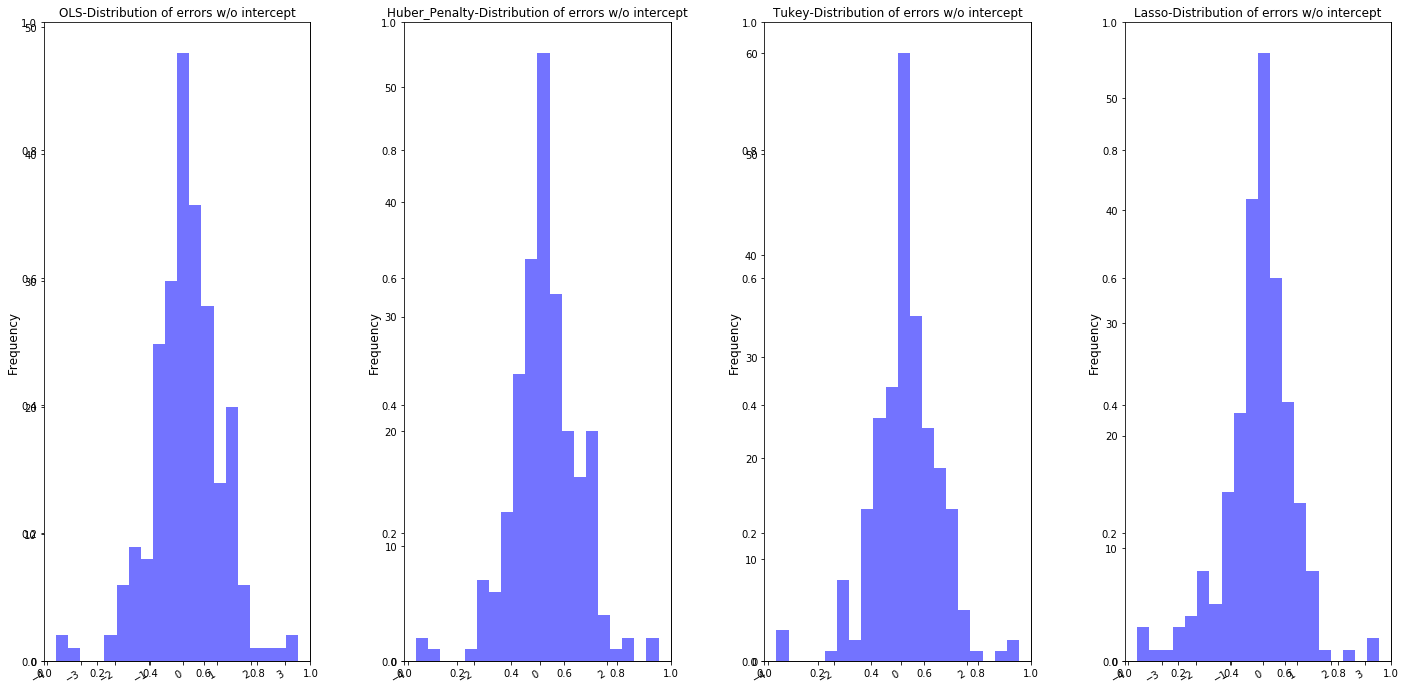

In [252]:
a,j,b,q = regr(stocks_1d_returns,regression,method = 'Simple OLS', include_constant = False)
c,d,z = regr(stocks_1d_returns,regression,method = 'Huber Penalty', include_constant = False)
e,f,l = regr(stocks_1d_returns,regression,method = 'Tukey', include_constant = False)
g,h,m = regr(stocks_1d_returns,regression,method = 'Lasso', include_constant = False)

# Creating a list of out of sample errors for the fat tail stocks

listq,listd,listf,listh = [],[],[],[]

for ticker in fat_tail_tickers:
    listq.extend(q[ticker].values)
    listd.extend(d[ticker].values)
    listf.extend(f[ticker].values)
    listh.extend(h[ticker].values)
    

list1 = [listq,listd,listf,listh]
list2 = ['OLS-Distribution of errors w/o intercept','Huber_Penalty-Distribution of errors w/o intercept',\
         'Tukey-Distribution of errors w/o intercept','Lasso-Distribution of errors w/o intercept']

plot_distributions(list1,list2)

Mean_Out_of_Sample_errors = pd.DataFrame(index = fat_tail_tickers, columns = ['OLS','Huber','Tukey','Lasso'])

for s in Mean_Out_of_Sample_errors.index:
    for k in Mean_Out_of_Sample_errors.columns:
        if k == 'OLS':
            Mean_Out_of_Sample_errors.loc[s,'OLS'] = q[s].abs().mean()
        elif k == 'Huber':
            Mean_Out_of_Sample_errors.loc[s,'Huber'] = d[s].abs().mean()
        elif k == 'Tukey':
            Mean_Out_of_Sample_errors.loc[s,'Tukey'] = f[s].abs().mean()
        elif k == 'Lasso':
            Mean_Out_of_Sample_errors.loc[s,'Lasso'] = h[s].abs().mean()
            
print('Mean_Out_of_Sample_errors for fat tail stocks')
Mean_Out_of_Sample_errors

### Conclusion:
    As we can see for the fat tailed stocks the absolute mean standardized residuals for out of sample data is the lowest among the Tukey method when compared with Huber and simple OLS methods.
    From the plots we can observe the standardized out of sample residuals which are close to 0 are the highest in the Tukey penalty function.

#### Analysis on various Penalty functions for standardized error residuals with the intercept

Mean_Out_of_Sample_standardized_errors for fat tail stocks


,OLS,Huber,Tukey,Lasso
EVRG,0.889748,0.832106,0.825503,0.865433
CHTR,0.89486,0.824722,0.837743,0.796278
FOXA,0.501632,0.50197,0.501849,0.510796
LBRDK,0.826045,0.882027,0.876878,0.73376
GLIBA,0.816625,0.88729,0.86012,0.791369
XLNX,0.758855,0.752409,0.756525,0.790281
OLED,1.08019,1.01172,0.966934,0.762483
CELG,0.661522,0.591419,0.596988,0.626927
SAGE,0.774516,0.822295,0.849569,0.917705
IMMU,0.816313,0.800965,0.800381,0.781101


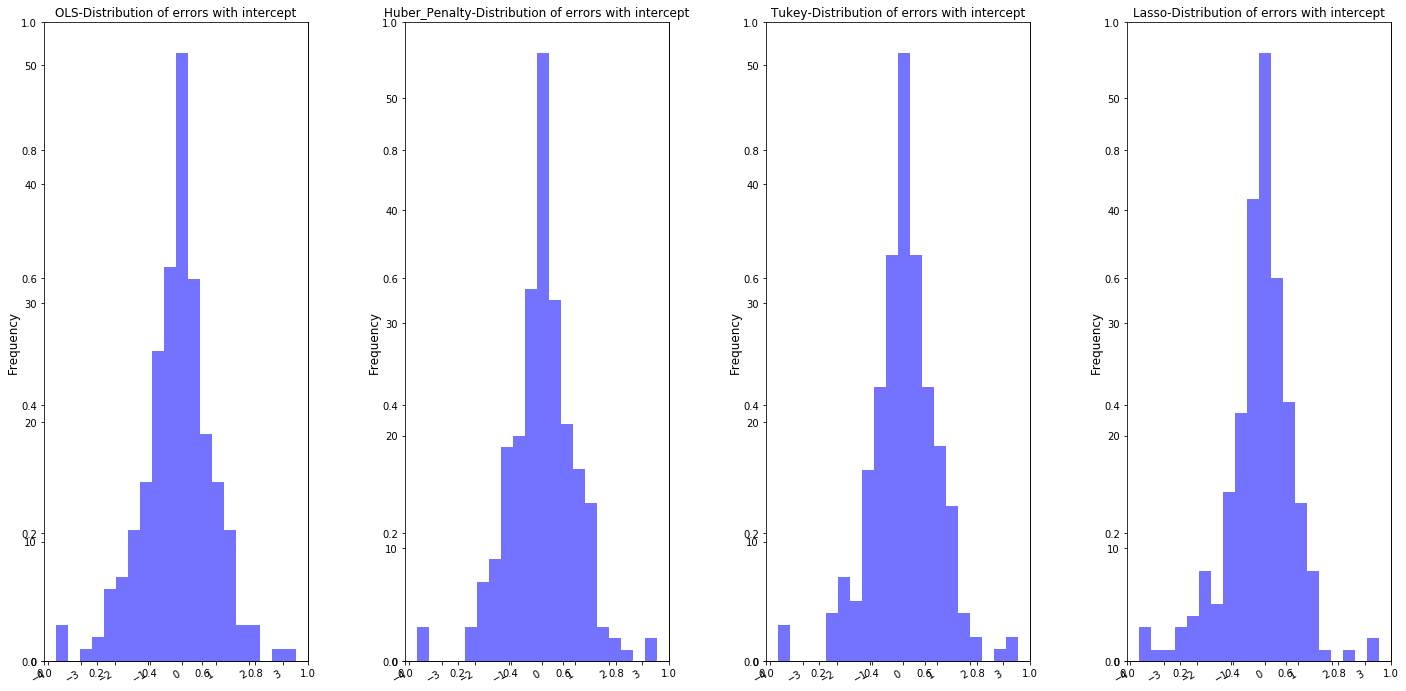

In [253]:
a,j,b,q = regr(stocks_1d_returns,regression,method = 'Simple OLS', include_constant = True)
c,d,z = regr(stocks_1d_returns,regression,method = 'Huber Penalty', include_constant = True)
e,f,l = regr(stocks_1d_returns,regression,method = 'Tukey', include_constant = True)
g,h,m = regr(stocks_1d_returns,regression,method = 'Lasso', include_constant = True)

listq,listd,listf,listh = [],[],[],[]

for ticker in fat_tail_tickers:
    listq.extend(q[ticker].values)
    listd.extend(d[ticker].values)
    listf.extend(f[ticker].values)
    listh.extend(h[ticker].values)
    

list1 = [listq,listd,listf,listh]
list2 = ['OLS-Distribution of errors with intercept','Huber_Penalty-Distribution of errors with intercept','Tukey-Distribution of errors with intercept','Lasso-Distribution of errors with intercept']

plot_distributions(list1,list2)

Mean_Out_of_Sample_errors = pd.DataFrame(index = fat_tail_tickers, columns = ['OLS','Huber','Tukey','Lasso'])

for s in Mean_Out_of_Sample_errors.index:
    for k in Mean_Out_of_Sample_errors.columns:
        if k == 'OLS':
            Mean_Out_of_Sample_errors.loc[s,'OLS'] = q[s].abs().mean()
        elif k == 'Huber':
            Mean_Out_of_Sample_errors.loc[s,'Huber'] = d[s].abs().mean()
        elif k == 'Tukey':
            Mean_Out_of_Sample_errors.loc[s,'Tukey'] = f[s].abs().mean()
        elif k == 'Lasso':
            Mean_Out_of_Sample_errors.loc[s,'Lasso'] = h[s].abs().mean()
            
print('Mean_Out_of_Sample_standardized_errors for fat tail stocks')
Mean_Out_of_Sample_errors

#### Conclusion for with intercept case:
    As we can see for the fat tailed stocks the absolute mean standardized residuals for out of sample data is the lowest among the Tukey method when compared with Huber and simple OLS methods.
    From the plots we can observe the standardized out of sample residuals which are close to 0 are the highest in the Tukey penalty function when comparison is done among the Huber,Tukey and Simple OLS methods.

#### Quantile Quantile Plots for the out of sample residual errors for one fat tailed stock

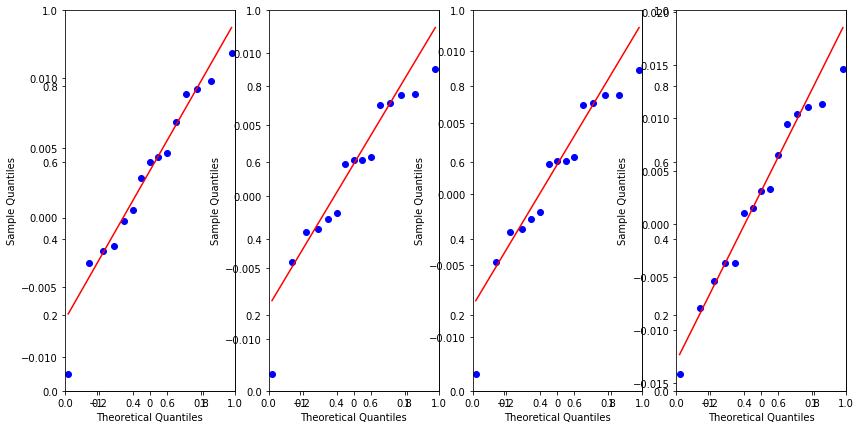

In [254]:
fig, ax = plt.subplots(nrows = 1,ncols = 4, figsize = (14, 7))
list = [b['EVRG'],c['EVRG'],e['EVRG'],g['EVRG']]
i = 1

for k in list:
    ax = fig.add_subplot(1, 4, i)
    sk.qqplot(k, ax = ax, line = 'q')
    i = i + 1
    
plt.show()

### Results Visualization:
    In the below analsyis I have analyzed the results of regressions visually.
    I have chosen Root Mean Square Error (RMSE) and the Mean Absolute Error (MAE) as the metrics to evaluate the performance of the above penalty functions.

In [255]:
rsd_r2,rsd_out_r2,rsd_ols_raw,rsd_ols_adj = regr(stocks_1d_returns,regression,method = 'Simple OLS', include_constant = False)
rsdc_r2,rsdc_out_r2,rsdc_ols_raw,rsdc_ols_adj = regr(stocks_1d_returns,regression,method = 'Simple OLS', include_constant = True)
rsd_hbr_raw, rsd_hbr_adj,rsd_hbr_out_r2  = regr(stocks_1d_returns,regression,method = 'Huber Penalty', include_constant = False)
rsdc_hbr_raw,rsdc_hbr_adj,rsdc_hbr_out_r2 = regr(stocks_1d_returns,regression,method = 'Huber Penalty', include_constant = True)
rsd_tky_raw, rsd_tky_adj,rsd_tky_out_r2  = regr(stocks_1d_returns,regression,method = 'Tukey', include_constant = False)
rsdc_tky_raw,rsdc_tky_adj,rsdc_tky_out_r2 = regr(stocks_1d_returns,regression,method = 'Tukey', include_constant = True)
rsd_lasso_raw, rsd_lasso_adj,rsd_lasso_out_r2  = regr(stocks_1d_returns,regression,method = 'Lasso', include_constant = False)
rsdc_lasso_raw,rsdc_lasso_adj,rsdc_lasso_out_r2 = regr(stocks_1d_returns,regression,method = 'Lasso', include_constant = True)

In [256]:
# sqaured error list
err_raw  = [rsd_ols_raw**2,rsd_hbr_raw**2,rsd_tky_raw**2,rsd_lasso_raw**2]
err_adj  = [rsd_ols_adj**2,rsd_hbr_adj**2,rsd_tky_adj**2,rsd_lasso_adj**2]
errc_raw = [rsdc_ols_raw**2,rsdc_hbr_raw**2,rsdc_tky_raw**2,rsdc_lasso_raw**2]
errc_adj = [rsdc_ols_adj**2,rsdc_hbr_adj**2,rsdc_tky_adj**2,rsdc_lasso_adj**2]

# abs list
abs_raw  = [rsd_ols_raw.abs(),rsd_hbr_raw.abs(),rsd_tky_raw.abs(),rsd_lasso_raw.abs()]
abs_adj  = [rsd_ols_adj.abs(),rsd_hbr_adj.abs(),rsd_tky_adj.abs(),rsd_lasso_adj.abs()]
absc_raw = [rsdc_ols_raw.abs(),rsdc_hbr_raw.abs(),rsdc_tky_raw.abs(),rsdc_lasso_raw.abs()]
absc_adj = [rsdc_ols_adj.abs(),rsdc_hbr_adj.abs(),rsdc_tky_adj.abs(),rsdc_lasso_adj.abs()]

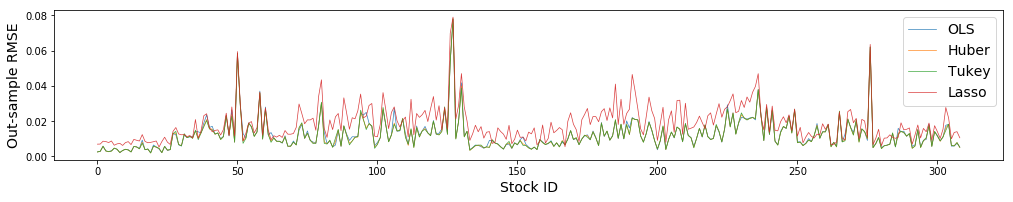

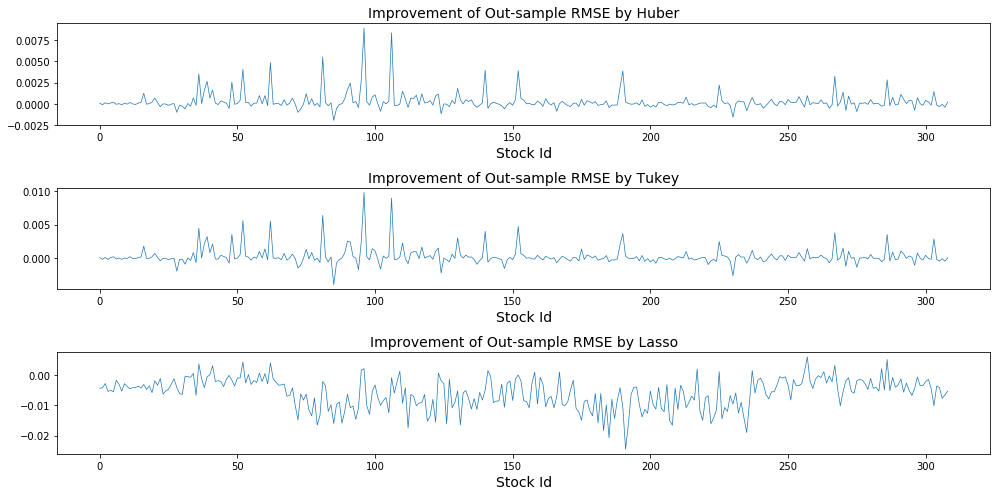

In [257]:
keys = ["OLS","Huber","Tukey","Lasso"]

plt.figure(figsize=[17,2.75])

for i in range(len(keys)):
    plt.plot(err_raw[i].mean().values**0.5,linewidth=0.7,alpha=0.9)
plt.xlabel("Stock ID",fontsize = 14)
plt.ylabel("Out-sample RMSE",fontsize = 14)
plt.legend(keys,fontsize = 14)


fig, ax = plt.subplots(nrows = 1,ncols = 3, figsize = (14, 7))
j = 1

# improvement raw err squared wo const
for i in range(len(keys)-1):
    plt.subplot(3,1,j)
    plt.plot(err_raw[0].mean().values**0.5-err_raw[i+1].mean().values**0.5,linewidth = 0.7)
    plt.xlabel("Stock Id",fontsize = 14)
    plt.title("Improvement of Out-sample RMSE by "+keys[i+1],fontsize = 14)
    j = j + 1
    
plt.tight_layout()
plt.show()

#### Conclusion for regression without intercept when benchmark is RMSE:
    1) The improvement in raw error squared over Simple OLS is more for Tukey when compared with other methods as we can visualize through the scale of y-axis.

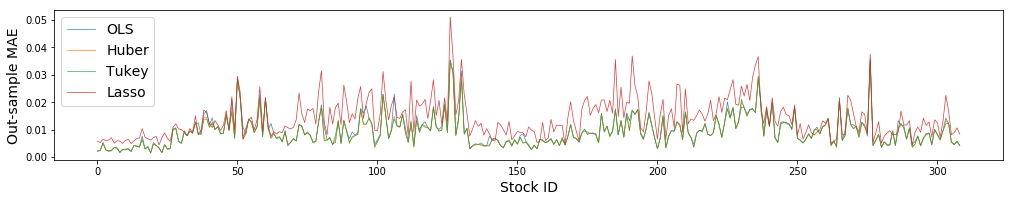

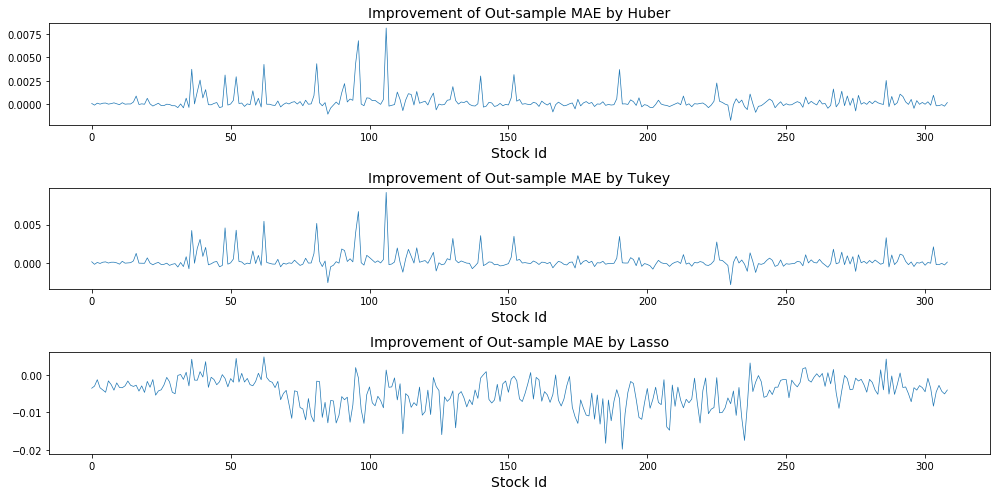

In [258]:
keys = ["OLS","Huber","Tukey","Lasso"]

plt.figure(figsize=[17,2.75])

for i in range(len(keys)):
    plt.plot(abs_raw[i].mean().values,linewidth=0.7,alpha=0.9)
plt.xlabel("Stock ID",fontsize = 14)
plt.ylabel("Out-sample MAE",fontsize = 14)
plt.legend(keys,fontsize = 14)


fig, ax = plt.subplots(nrows = 1,ncols = 3, figsize = (14, 7))
j = 1

# improvement raw err squared wo const
for i in range(len(keys)-1):
    plt.subplot(3,1,j)
    plt.plot(abs_raw[0].mean().values-abs_raw[i+1].mean().values,linewidth = 0.7)
    plt.xlabel("Stock Id",fontsize = 14)
    plt.title("Improvement of Out-sample MAE by "+keys[i+1],fontsize = 14)
    j = j + 1
    
plt.tight_layout()
plt.show()

#### Conclusion for regression without intercept when benchmark is MAE:
    1) The improvement in raw error squared over Simple OLS is more for Tukey when compared with other methods.

#### Optimizing the Huber Parameter (assuming with intercept regressions)

In [259]:
time_start = tm.time()
in_sample_r2,out_sample_r2,raw,adj = regr(stocks_1d_returns,regression,method = 'Simple OLS',include_constant = True)
time_ols = tm.time() - time_start
time_ols

2.5435807704925537

In [260]:
idx = ["M-RMSE Raw","M-RMSE Adj","M-MAE Raw","M-MAE Adj","RunTime"]

param_list = np.linspace(0.1,6.0,num = 10)
res_huber = pd.DataFrame(columns = param_list,index = idx)
for i in range(len(param_list)):
    time_start = tm.time()
    raw, adj,out_sample_r2 = regr(stocks_1d_returns,regression,method = 'Huber Penalty',include_constant = True, t = param_list[i], c = 4.685)
    time_exe = tm.time() - time_start
    err_r = (((raw**2).mean())**0.5).mean()
    err_a = (((adj**2).mean())**0.5).mean()
    abs_r = raw.abs().mean().mean()
    abs_a = adj.abs().mean().mean()
    res_huber[param_list[i]] = [err_r,err_a,abs_r,abs_a,time_exe]
res_huber = res_huber.T

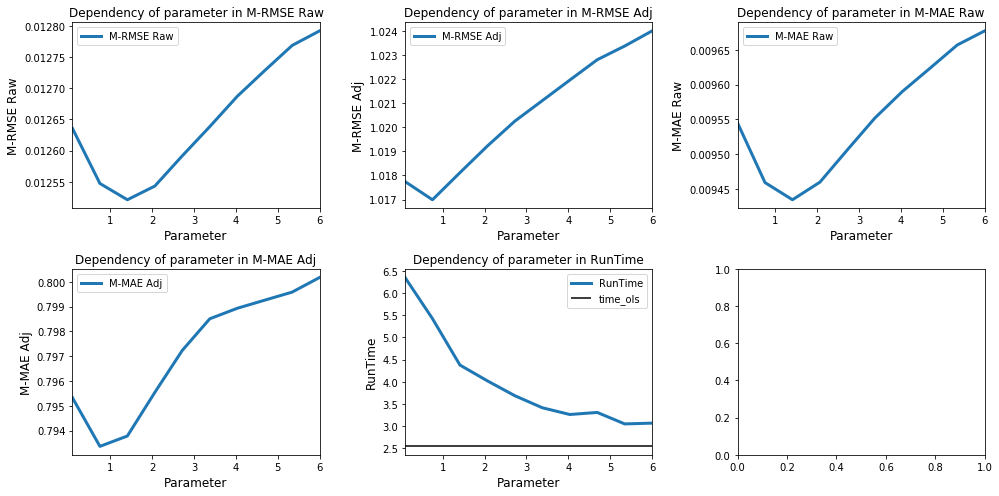

In [261]:
fig, ax = plt.subplots(nrows = 2,ncols = 3, figsize = (14, 7))
j = 1

for key in idx:
    plt.subplot(2,3,j)
    res_huber[key].plot(linewidth = 3.0)
    plt.title("Dependency of parameter in "+key,fontsize = 12)
    plt.xlabel("Parameter",fontsize = 12)
    plt.ylabel(key,fontsize = 12)
    j = j + 1 
    if key == 'RunTime':
        plt.hlines(time_ols,0.1,6, label = 'time_ols')
    plt.legend()
    
plt.tight_layout()
plt.show()

#### Conclusion:
    The figures above denote the dependencies of RMSE and MAE on the Huber parameter before and after the standardization 
    WITH intercept.

    1) For the RMSE and MAE before standardization, there exist a certain minimum, almost 1.4 (close to the default value,1.345, in python) in this simulation.
    For the RMSE and MAE after standardization, the errors tend to grow with respect to the parameter, however, the growth rates become smaller as the parameter grows.
        2) The computational cost: Regression with the higher parameter takes the less time to run regression.This observations is natural because the Huber regression with higher parameter is almost similar to performing a simple OLS regression.

#### Optimizing the Tukey Parameter ( assuming with intercept regressions)

In [262]:
param_list = np.linspace(0.5,8.0,num = 10)
res_Tukey = pd.DataFrame(columns = param_list,index = idx)
for i in range(len(param_list)):
    time_start = tm.time()
    raw, adj,out_sample_r2 = regr(stocks_1d_returns,regression,method = 'Tukey',include_constant = True ,c = param_list[i])
    time_exe = tm.time() - time_start
    err_r = (((raw**2).mean())**0.5).mean()
    err_a = (((adj**2).mean())**0.5).mean()
    abs_r = raw.abs().mean().mean()
    abs_a = adj.abs().mean().mean()
    res_Tukey[param_list[i]] = [err_r,err_a,abs_r,abs_a,time_exe]
res_Tukey = res_Tukey.T

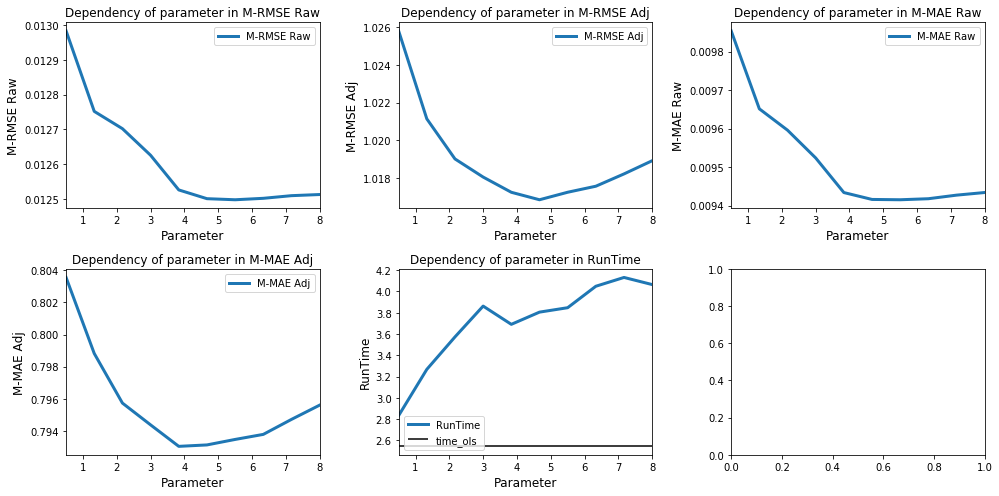

In [263]:
fig, ax = plt.subplots(nrows = 2,ncols = 3, figsize = (14, 7))
j = 1

for key in idx:
    plt.subplot(2,3,j)
    res_Tukey[key].plot(linewidth = 3.0)
    plt.title("Dependency of parameter in "+key,fontsize = 12)
    plt.xlabel("Parameter",fontsize = 12)
    plt.ylabel(key,fontsize = 12)
    j = j + 1 
    if key == 'RunTime':
        plt.hlines(time_ols,0.5,8, label = 'time_ols')
    plt.legend()
    
plt.tight_layout()
plt.show()

#### Conclusion
    The above figures denote the dependencies of RMSE and MAE on the Tukey parameter before and after standardization WITH the intercept.

    For all the metrics before standardization, we observe the parameter c = 5 for which we obtin the minumum is close to the default value of 4.685 in python).

    Forthe medtrics after standardization, the errors reduce initially with the increase in parameter but then they start growing with the parameter albeit at a slow rate.
    The computational time grows as the Tukey parameter increases in contrast to the Huber Penalty upper limit. This is primarily due to the Tukey algorithm. The tendency to find multiple minimums in the bisquare derivative function increases which can lead to the increase in time of computation. 

### Conclusion:

    The above analysis yields that Tukey Penalty function performs th best among the penalty functions and the regression with intercept provide better results.